<h1>MLP Predictor for stock data</h1>

<h3>Author: Danilo Filippo Reiszel Pereira</h3>
<strong>Univesidade Federal do Rio de Janeiro</strong>

<p>This notebook contains the creation several Multi-layer Perceptron models to predict D+1 closing prices of stocks</p>

In [48]:
import sys, os
sys.path.append('../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

%matplotlib inline

<h3>Global Params</h3>

Setting global params such as directory of data, save directories and plot params

In [2]:
pathPETR4 = '../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../data/forex/USDBRL/diario/USDBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
if not os.path.exists(saveVarDir):
    os.makedirs(saveVarDir)
    print('saveVarDir created')
else:
    print('saveVarDir already exists!')
saveFigDir = './Figures'
if not os.path.exists(saveFigDir):
    os.makedirs(saveFigDir)
    print('saveFigDir created')
else:
    print('saveFigDir already exists!')
saveModelDir = './Models'
if not os.path.exists(saveModelDir):
    os.makedirs(saveModelDir)
    print('saveModelDir created')
else:
    print('saveModelDir already exists!')
saveFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

saveVarDir already exists!
saveFigDir already exists!
saveModelDir already exists!


<h3>Data Acquisition and Preprocessing</h3>

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

<strong>Parameters for trend extraction:</strong>
<ul>
    <li>Column: Close</li>
    <li>Decompose model: Additive</li>
    <li>Fitting Order: 1 (by default)</li>
    <li>Window Size: 6</li>
    <li>Fitting Weigths Model: Autocorrelation</li>
    <li>Fitting Weigths Model Window Size: 18</li>
</ul>

In [3]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    deTrendParams = {'column': 'Close', 'window': 6, 'model': decomposeModel, 
                                     'weightModel': 'window_acorr', 'weightModelWindow': 18},
                    colPrefix = 'PETR4',
                    dropNan = True
                   )

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True
                  )

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True
                   )


end_time = time.time()
print 'Time to acquire and process data: '+str(end_time-init_time)+' seconds'

Time to acquire and process data: 16.3487808704 seconds


<h3>Dataset concatenation and selection of wich features to feed to the model</h3>

In [4]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = ['PETR4_Close_resid', 
                'PETR4_Close_rollStd20', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns',
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff',
               ]

<h3>Creation of feature matrix and output array, split of data in Train and Test sets</h3>

In [5]:
xTrain, yTrain, xTest, yTest = prepData(df = df, 
                                        columnsToUse = columnsToUse, columnToPredict = 'PETR4_Close_resid', 
                                        nDelays = 10, testSetSize = len(df['2017'])
                                       )

numberOfTrainBatches = len(xTrain)
numberOTestBatches = len(xTest)
numberOfTrainInputs = len(xTrain[0])
print 'Number of train batches: {}'.format(numberOfTrainBatches)
print 'Number of test batches: {}'.format(numberOTestBatches)
print 'Number of inputs per batch: {}'.format(numberOfTrainInputs)

Number of train batches: 4185
Number of test batches: 175
Number of inputs per batch: 40


<h3>Feature Scalling</h3>

Technique used: Normalisation

In [6]:
xNormScaler = MinMaxScaler(feature_range = (-1,1))
xNormScaler.fit(xTrain)

yNormScaler = MinMaxScaler(feature_range = (-1,1))
yNormScaler.fit(yTrain)

xNormTrain = xNormScaler.transform(xTrain)
xNormTest  = xNormScaler.transform(xTest)

yNormTrain = yNormScaler.transform(yTrain)

<h3>Parameters for traning</h3>

In [7]:
inputDim = xTrain.shape[1]

nInits = 2 # number of times a topology will be trained
maxNeuronsInHiddenLayer = 40 # upper limit for number of neurons in hidden layer

<h3>Training of MLP model</h3>

In [8]:
# optimizer definition
optimizer = optimizers.SGD(lr=0.003, momentum=0.00, decay=0.0, nesterov=False)

# callbacks definitions
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto')

# regularization
reg = regularizers.l2(0.001)

init_time = time.time()

bestNormValLoss = np.Inf
bestNormFitHistory = None
bestNormHiddenLayer = 1

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpoint = ModelCheckpoint('./Models/PETR4_MLPi40h{}_norm.h5'.format(nNeurons), save_best_only=True)
    for init in range(nInits):
        model = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim, kernel_regularizer = reg),
                            Dense(1, activation = 'linear', kernel_regularizer = reg)
                           ])
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = model.fit(xNormTrain, 
                               yNormTrain, 
                               epochs = 2000,
                               verbose = 0,
                               shuffle = True,
                               validation_split = 0.15, 
                               callbacks = [modelCheckpoint,
                                            earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestNormValLoss:
            bestNormValLoss = min(fitHistory.history['val_loss'])
            bestNormFitHistory = fitHistory
            bestNormHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 15145.1039481 seconds


In [9]:
print 'Best model ({} inputs): {}x1'.format(inputDim, bestNormHiddenLayer)
bestNormModel = load_model('./Models/PETR4_MLPi40h{}_norm.h5'.format(bestNormHiddenLayer))
bestNormModel.summary()

Best model (40 inputs): 1x1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 41        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


In [10]:
#SVG(model_to_dot(bestNormModel).create(prog='dot', format='svg'))

<h3>Plot of RMSE per epoch, for Training Set and Validation Set</h3>
Note: Validation set is not always the same as Test Set; it's randomly generated from the Training Set

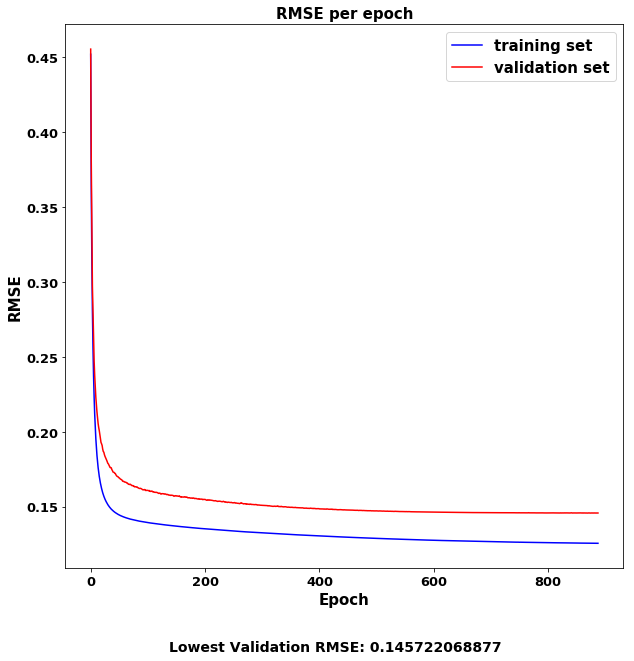

In [11]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestNormFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestNormFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestNormFitHistory.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_norm', 'pdf'), bbox_inches='tight')

<h3>Plot of predictions made using the Test Set</h3>

(<matplotlib.figure.Figure at 0x7fd880bdea10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd880cd4f90>)

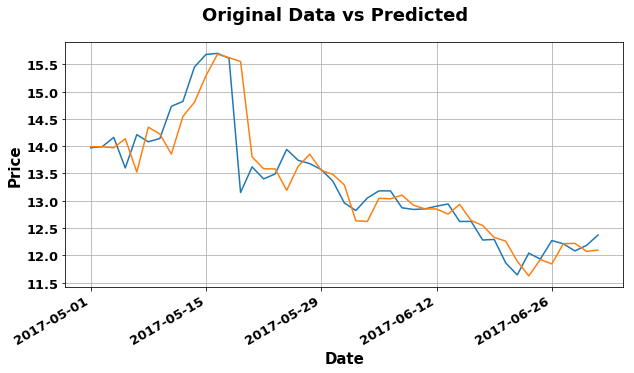

In [12]:
predictionsNorm = bestNormModel.predict(xNormTest)
predictionsNorm = yNormScaler.inverse_transform(predictionsNorm)
predictionsNorm_clean = []
for p in predictionsNorm:
    predictionsNorm_clean.extend(p)
predictionsNormSeries = pd.Series(predictionsNorm_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsNormSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

<h3>Plot of errors from Trend Prediction and Trend + ANN Prediction</h3>

(<matplotlib.figure.Figure at 0x7fd880d145d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd8afed6110>)

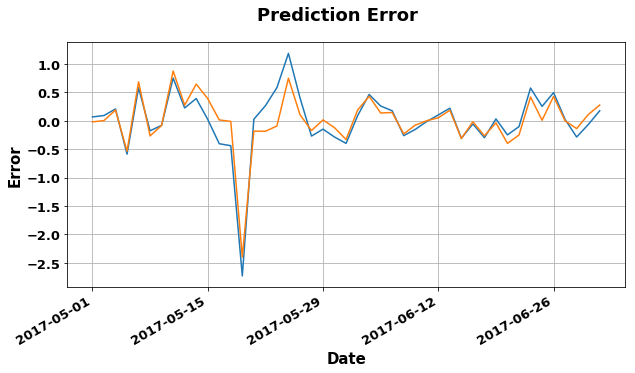

In [13]:
plotSeries([df['PETR4_Close_resid'], df['PETR4_Close_resid'] - predictionsNormSeries],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'Error')

In [14]:
xNormAll = np.append(xNormTrain, xNormTest, axis = 0)
predictionsNormAll = bestNormModel.predict(xNormAll)
predictionsNormAll = yNormScaler.inverse_transform(predictionsNormAll)
predictionsNormAll_clean = []
for p in predictionsNormAll:
    predictionsNormAll_clean.extend(p)
predictionsNormAllSeries = pd.Series(predictionsNormAll_clean, index = df[10:].index)

<h3>Retraining same topologies, but using standardization as scaling technique</h3>

In [52]:
from sklearn.preprocessing import StandardScaler

xStdScaler = StandardScaler()
xStdScaler.fit(xTrain)

yStdScaler = StandardScaler()
yStdScaler.fit(yTrain)

xStdTrain = xStdScaler.transform(xTrain)
xStdTest  = xStdScaler.transform(xTest)

yStdTrain = yStdScaler.transform(yTrain)
yStdTest = yStdScaler.transform(yTest)

In [16]:
init_time = time.time()

bestStdValLoss = np.Inf
bestStdFitHistory = None
bestStdHiddenLayer = 1

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointStd = ModelCheckpoint('./Models/PETR4_MLPi40h{}_std.h5'.format(nNeurons), save_best_only=True)
    for init in range(nInits):
        modelStd = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim, kernel_regularizer = reg),
                               Dense(1, activation = 'linear', kernel_regularizer = reg)
                              ])
        modelStd.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelStd.fit(xStdTrain, 
                                  yStdTrain, 
                                  epochs = 2000,
                                  verbose = 0,
                                  shuffle = True,
                                  validation_split = 0.15, 
                                  callbacks = [modelCheckpointStd,
                                               earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestStdValLoss:
            bestStdValLoss = min(fitHistory.history['val_loss'])
            bestStdFitHistory = fitHistory
            bestStdHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 643.738124847 seconds


In [17]:
print 'Best model ({} inputs): {}x1'.format(inputDim, bestStdHiddenLayer)
bestModelStd = load_model('./Models/PETR4_MLPi40h{}_std.h5'.format(bestStdHiddenLayer))
bestModelStd.summary()

Best model (40 inputs): 16x1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 16)                656       
_________________________________________________________________
dense_224 (Dense)            (None, 1)                 17        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


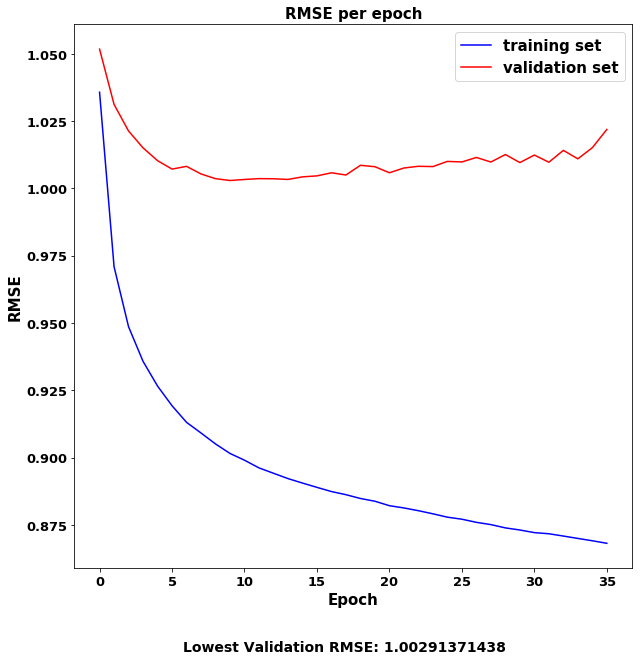

In [18]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestStdFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestStdFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestStdFitHistory.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_std', 'pdf'), bbox_inches='tight')

(<matplotlib.figure.Figure at 0x7fd869896510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd8696f4850>)

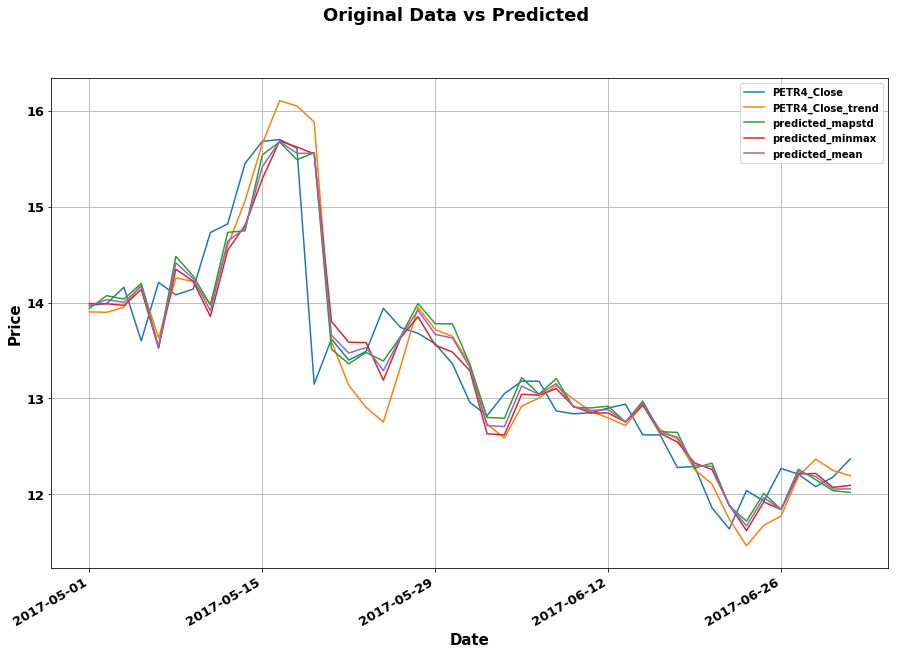

In [47]:
predictionsStd = yStdScaler.inverse_transform(bestModelStd.predict(xStdTest)).reshape(-1)
predictionsStdSeries = pd.Series(predictionsStd, index = df['2017'].index)

predicted_PETR4_norm = pd.Series(df['PETR4_Close_trend'] + predictionsNormSeries, name = 'predicted_minmax')
predicted_PETR4_std = pd.Series(df['PETR4_Close_trend'] + predictionsStdSeries, name = 'predicted_mapstd')
predicted_PETR4_mean = pd.Series((predicted_PETR4_norm + predicted_PETR4_std)/2, name = 'predicted_mean')

plotSeries2([df['PETR4_Close'], 
            df['PETR4_Close_trend'],
            predicted_PETR4_std,
            predicted_PETR4_norm,
            predicted_PETR4_mean],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

In [53]:
bestModelStd.evaluate(xStdTest, yStdTest)

 32/175 [====>.........................] - ETA: 4s

[0.57715086170605245, 0.52834957344191413]

(<matplotlib.figure.Figure at 0x7fd870b89290>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd870bfd350>)

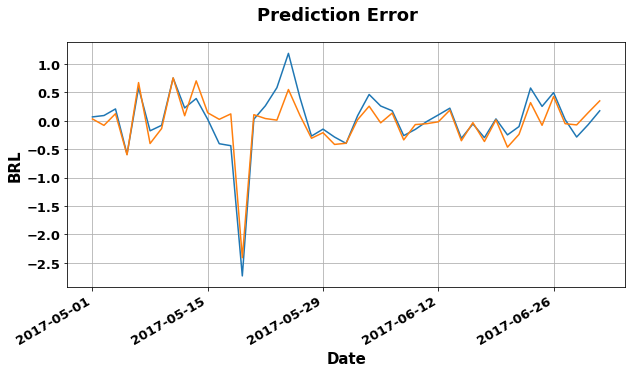

In [20]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsStdSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

<h3>Retraining MLPs using only the delayed series as input, no auxiliar series, for comparative purposes</h3>

In [21]:
xSimpleTrain, ySimpleTrain, xSimpleTest, ySimpleTest = prepData(df = df, 
                                                                columnsToUse = ['PETR4_Close_resid'], columnToPredict = 'PETR4_Close_resid', 
                                                                nDelays = 10, testSetSize = len(df['2017']))

xSimpleScaler = MinMaxScaler()
xSimpleScaler.fit(xSimpleTrain)

ySimpleScaler = MinMaxScaler()
ySimpleScaler.fit(ySimpleTrain)

xSimpleTrain = xSimpleScaler.transform(xSimpleTrain)
xSimpleTest  = xSimpleScaler.transform(xSimpleTest)

ySimpleTrain = ySimpleScaler.transform(ySimpleTrain)

In [22]:
inputDim = xSimpleTrain.shape[1]

nInits = 2 # number of times a topology will be trained
maxNeuronsInHiddenLayer = 10 # upper limit for number of neurons in hidden layer

bestSimpleValLoss = np.Inf
bestSimpleFitHistory = None
bestSimpleHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointSimple = ModelCheckpoint('./Models/PETR4_MLPi10h{}_norm.h5'.format(nNeurons), save_best_only=True)
    for init in range(nInits):
        modelSimple = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim, kernel_regularizer = reg),
                                  Dense(1, activation = 'linear', kernel_regularizer = reg)
                                 ])
        modelSimple.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelSimple.fit(xSimpleTrain, 
                                     ySimpleTrain, 
                                     epochs = 2000,
                                     verbose = 0,
                                     shuffle = True,
                                     validation_split = 0.15, 
                                     callbacks = [modelCheckpointSimple,
                                                  earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestSimpleValLoss:
            bestSimpleValLoss = min(fitHistory.history['val_loss'])
            bestSimpleFitHistory = fitHistory
            bestSimpleHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 5669.61886406 seconds


In [23]:
print 'Best model ({} inputs): {}x1'.format(inputDim, bestSimpleHiddenLayer)
bestModelSimple = load_model('./Models/PETR4_MLPi10h{}_norm.h5'.format(bestSimpleHiddenLayer))
bestModelSimple.summary()

Best model (10 inputs): 1x1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_323 (Dense)            (None, 1)                 11        
_________________________________________________________________
dense_324 (Dense)            (None, 1)                 2         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


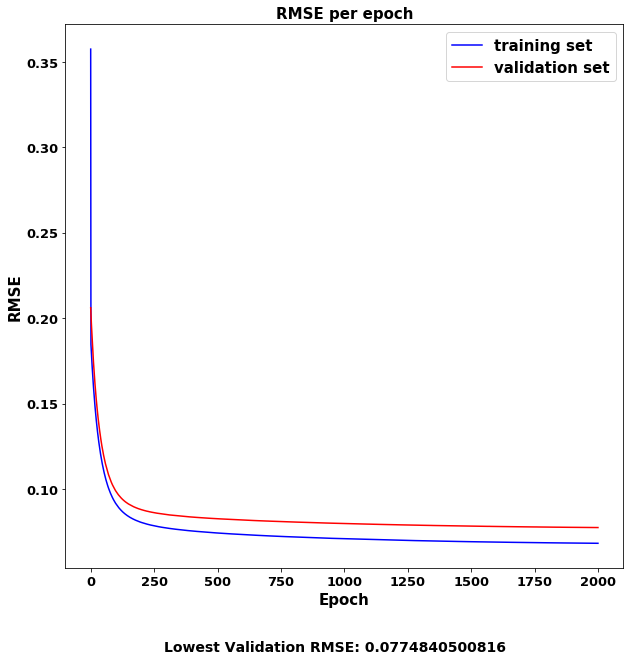

In [24]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestSimpleFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestSimpleFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestSimpleFitHistory.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_simple', 'pdf'), bbox_inches='tight')

(<matplotlib.figure.Figure at 0x7fd86d827cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd86d7542d0>)

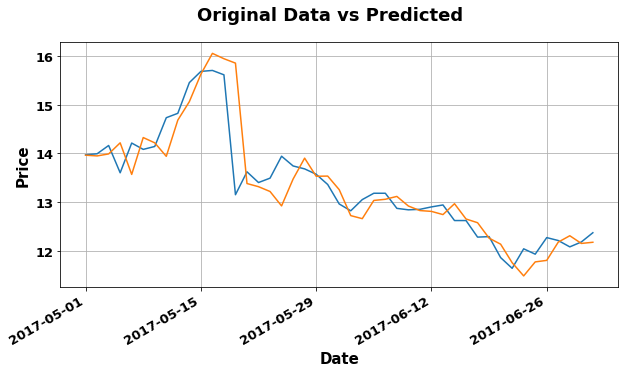

In [25]:
predictionsSimple = bestModelSimple.predict(xSimpleTest)
predictionsSimple = ySimpleScaler.inverse_transform(predictionsSimple)
predictionsSimple_clean = []
for p in predictionsSimple:
    predictionsSimple_clean.extend(p)
predictionsSimpleSeries = pd.Series(predictionsSimple_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsSimpleSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

(<matplotlib.figure.Figure at 0x7fd870bac090>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd870a66f10>)

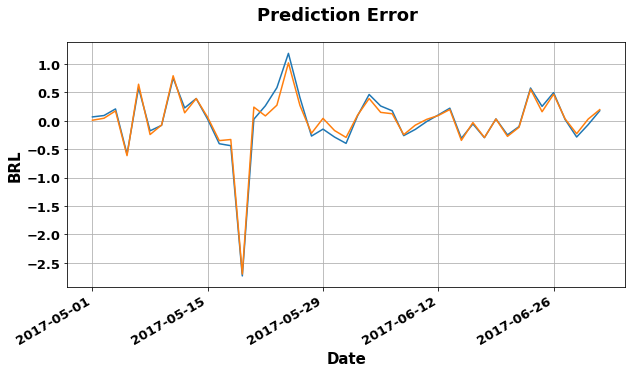

In [26]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsSimpleSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

In [27]:
xNormSimpleAll = np.append(xSimpleTrain, xSimpleTest, axis = 0)
predictionsNormSimpleAll = bestModelSimple.predict(xNormSimpleAll)
predictionsNormSimpleAll = ySimpleScaler.inverse_transform(predictionsNormSimpleAll)
predictionsNormSimpleAll_clean = []
for p in predictionsNormSimpleAll:
    predictionsNormSimpleAll_clean.extend(p)
predictionsNormSimpleAllSeries = pd.Series(predictionsNormSimpleAll_clean, index = df[10:].index)

(<matplotlib.figure.Figure at 0x7fd86d373150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd86d87df50>)

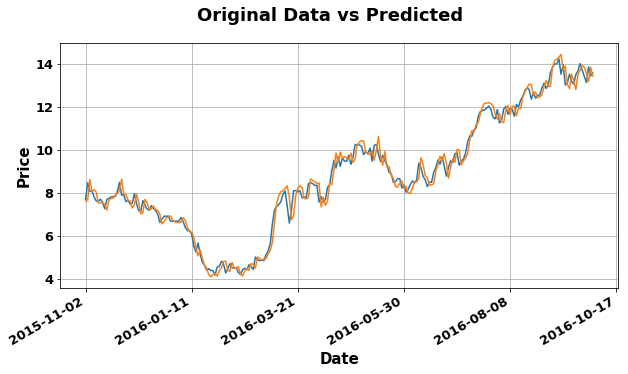

In [28]:
plotSeries([df['PETR4_Close'], 
#            df['PETR4_Close_trend'],
            (df['PETR4_Close_trend'] + predictionsNormSimpleAllSeries)
           ],
           initialPlotDate = '2015-11', finalPlotDate = '2016-09',
           title = 'Original Data vs Predicted', ylabel = 'Price')

(<matplotlib.figure.Figure at 0x7fd86d3818d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd86d3735d0>)

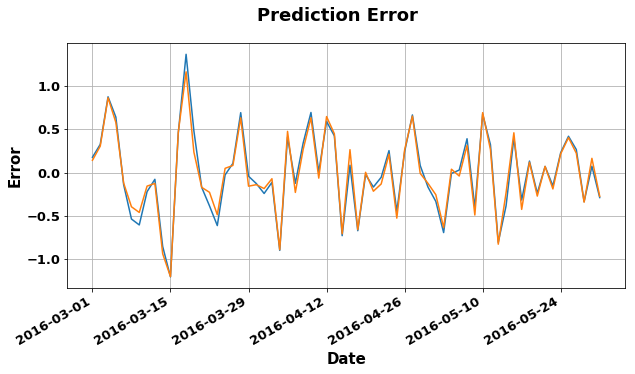

In [29]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsNormSimpleAllSeries)],
           plotZeroLine = True,
           initialPlotDate = '2016-03', finalPlotDate = '2016-05',
           title = 'Prediction Error', ylabel = 'Error')

<h3>Retraining MLPs using only the delayed series as input, no auxiliar series, and StandardScaler</h3>

In [30]:
xSimpleStdTrain, ySimpleStdTrain, xSimpleStdTest, ySimpleStdTest = prepData(df = df, 
                                                                columnsToUse = ['PETR4_Close_resid'], columnToPredict = 'PETR4_Close_resid', 
                                                                nDelays = 10, testSetSize = len(df['2017']))

xSimpleStdScaler = StandardScaler()
xSimpleStdScaler.fit(xSimpleStdTrain)

ySimpleStdScaler = StandardScaler()
ySimpleStdScaler.fit(ySimpleStdTrain)

xSimpleStdTrain = xSimpleStdScaler.transform(xSimpleStdTrain)
xSimpleStdTest  = xSimpleStdScaler.transform(xSimpleStdTest)

ySimpleStdTrain = ySimpleStdScaler.transform(ySimpleStdTrain)

In [31]:
inputDim = xSimpleTrain.shape[1]

nInits = 2 # number of times a topology will be trained
maxNeuronsInHiddenLayer = 10 # upper limit for number of neurons in hidden layer

bestSimpleStdValLoss = np.Inf
bestSimpleStdFitHistory = None
bestSimpleStdHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointSimpleStd = ModelCheckpoint('./Models/PETR4_MLPi10h{}_std.h5'.format(nNeurons), save_best_only=True)
    for init in range(nInits):
        modelSimpleStd = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim, kernel_regularizer = reg),
                                     Dense(1, activation = 'linear', kernel_regularizer = reg)
                                    ])
        modelSimpleStd.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelSimpleStd.fit(xSimpleTrain, 
                                     ySimpleTrain, 
                                     epochs = 2000,
                                     verbose = 0,
                                     shuffle = True,
                                     validation_split = 0.15, 
                                     callbacks = [modelCheckpointSimpleStd,
                                                  earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestSimpleStdValLoss:
            bestSimpleStdValLoss = min(fitHistory.history['val_loss'])
            bestSimpleStdFitHistory = fitHistory
            bestSimpleStdHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 5778.73048592 seconds


In [32]:
print 'Best model ({} inputs): {}x1'.format(inputDim, bestSimpleStdHiddenLayer)
bestModelSimpleStd = load_model('./Models/PETR4_MLPi10h{}_std.h5'.format(bestSimpleStdHiddenLayer))
bestModelSimpleStd.summary()

Best model (10 inputs): 1x1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_363 (Dense)            (None, 1)                 11        
_________________________________________________________________
dense_364 (Dense)            (None, 1)                 2         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


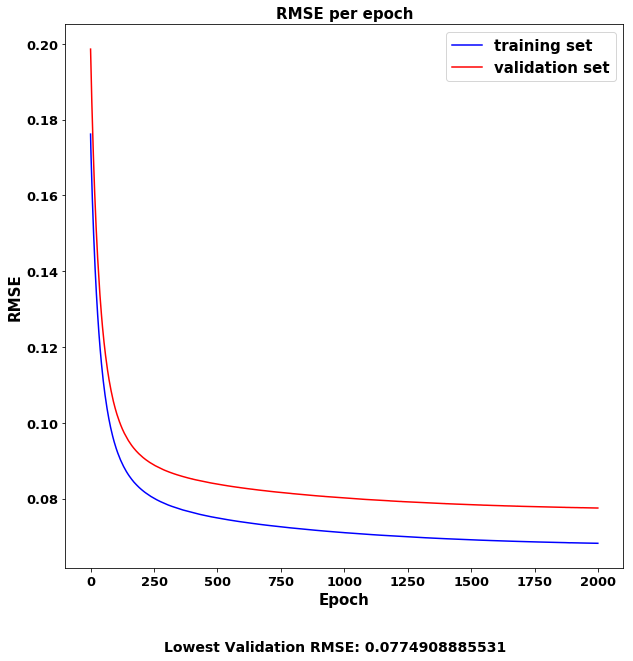

In [33]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestSimpleStdFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestSimpleStdFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestSimpleStdFitHistory.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_simpleStd', 'pdf'), bbox_inches='tight')

(<matplotlib.figure.Figure at 0x7fd869ea2b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd869e64110>)

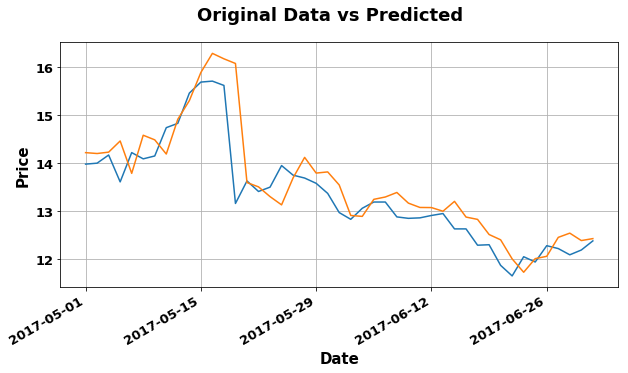

In [34]:
predictionsSimpleStd = bestModelSimpleStd.predict(xSimpleStdTest)
predictionsSimpleStd = ySimpleStdScaler.inverse_transform(predictionsSimpleStd)
predictionsSimpleStd_clean = []
for p in predictionsSimpleStd:
    predictionsSimpleStd_clean.extend(p)
predictionsSimpleStdSeries = pd.Series(predictionsSimpleStd_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsSimpleStdSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

(<matplotlib.figure.Figure at 0x7fd869e13310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd86d2e5390>)

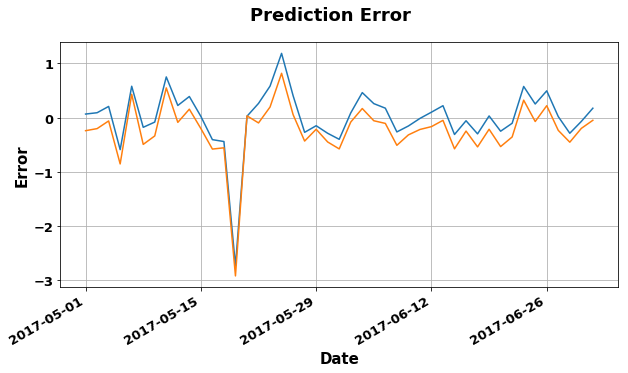

In [35]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsSimpleStdSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'Error')

In [43]:
def plotSeries2(series, title = None, ylabel = None, initialPlotDate = '', finalPlotDate = '', plotZeroLine = False, saveImg = False, saveDir = '', saveName = '', saveFormat = 'pdf'):
    """
    Plots the desired Series

    Parameters
    ----------
    series : pandas.Series object, pandas.Series array, or pandas.DataFrame object.
        Will plot the single Series if input is a single pandas.Series, plot all
        Series if input is an array of pandas.Series, or plot all dataframe columns
        if input is a pandas.DataFrame object. All plots will overlap in the same ax

    initialPlotDate, finalPlotDate : string (yyyy or yyyy-mm) or datetime,
    indicates which period of the series to plot. If none is provided, assumes
    first and last available samples, respectively.

    saveImg : bool, indicates wheter to save the generated plot or not

    saveDir: string, directory in wich to save generated plot

    saveName : string, set of desired lenghts to calculate moving averages

    saveFormat : string, saved image format. Default 'pdf'
    """
    if isinstance(series, pd.DataFrame):
        series = [series[column] for column in series.columns.values]
    series = [series] if isinstance(series, pd.Series) else series
    initialPlotDate = series[0][initialPlotDate].index[0] if initialPlotDate else series[0].index[0]
    finalPlotDate = series[0][finalPlotDate].index[-1] if finalPlotDate else series[0].index[-1]
    if not title:
        title = '{} ({})'.format(series[0].name, initialPlotDate.strftime('%d/%m/%Y')) if initialPlotDate == finalPlotDate else '{} ({} to {})'.format(series[0].name, initialPlotDate.strftime('%d/%m/%Y'), finalPlotDate.strftime('%d/%m/%Y'))
    if not ylabel:
        ylabel = series[0].name

    fig, ax = plt.subplots(figsize=(15,10), nrows = 1, ncols = 1)
    fig.suptitle(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    for s in series:
        d = pd.date_range(start=s[initialPlotDate:finalPlotDate].index[0], end=s[initialPlotDate:finalPlotDate].index[-1], freq="B")
        ax.plot(np.arange(len(s[initialPlotDate:finalPlotDate])), s[initialPlotDate:finalPlotDate])
        xticks = ax.get_xticks()
        xticklabels = [(d[0] + x).strftime('%Y-%m-%d') for x in xticks.astype(int)]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
    ax.autoscale(True, axis='x')
    ax.grid()
    fig.autofmt_xdate()
    plt.legend()
    if saveImg:
        saveName = saveName if saveName else '{}'.format(s[0].name)
        fig.savefig('{}/{}.{}'.format(saveDir, saveName, saveFormat), bbox_inches='tight')
    return fig, ax